# Seismic interpolation - analysis vs synthesis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from invwidget import inversion_widget
from scipy.signal import convolve
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from pylops.basicoperators import *
from pylops.utils import dottest
from pylops.optimization.basic import cgls
from pylops.optimization.sparsity import fista
from pylops import LinearOperator, MatrixMult, MemoizeOperator
from pylops.signalprocessing import FFT2D, Sliding1D, Sliding2D, Patch2D, Patch3D
from pylops.signalprocessing.sliding1d import sliding1d_design
from pylops.signalprocessing.sliding2d import sliding2d_design
from pylops.signalprocessing.sliding3d import sliding3d_design
from pylops.signalprocessing.patch2d import patch2d_design
from pylops.signalprocessing.patch3d import patch3d_design
from pylops.utils.describe import describe

In [2]:
inputfile = '../../pylops/testdata/marchenko/input.npz'
inputdata = np.load(inputfile)

x = inputdata['R'][50, :, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0]
par = {}
par['nx'], par['nt'] = x.shape
par['dx'] = inputdata['r'][0, 1] - inputdata['r'][0, 0]
par['dt'] = inputdata['t'][1] - inputdata['t'][0]

# add wavelet
wav = 0.3*inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :par['nt']]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par['nx'])).T
x = x*gain

# irregular subsampling
np.random.seed(5)
perc_subsampling=0.6
Nsub=int(np.round(par['nx']*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# regular subsampling
#iava = np.arange(par['nx'])[::5]
#Nsub = len(iava)

# Create restriction operator
Rop = Restriction((par['nx'], par['nt']), iava, axis=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

# Create fft operator
nfft=2**10
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], 
              sampling=[par['dx'], par['dt']])

# Data
y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape(par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^H(Opu)=400.0701114689233 - u^H(Op^Hv)=400.0701114689233


In [3]:
dimsd = x.shape
nwin = (20, 34)
nover = (10, 4)
nop = (64, 64)

Fop = FFT2D(nwin, nffts=nop)

nwins, dims, mwin_inends, dwin_inends = patch2d_design(dimsd, nwin, nover, nop)
Sop = Patch2D(Fop.H, dims, dimsd, nwin, nover, nop,
              tapertype='cosinesqrt', # 'cosine'
              )
#p = Sop.H * x.ravel()
p = Sop.div(x.ravel(), 50)
pmask = Sop.div(ymask.ravel(), 50)

dottest(Sop, Sop.shape[0],  Sop.shape[1], complexflag=2, atol=1e-2)

 540 570 600 630 660], end:[ 34  64  94 124 154 184 214 244 274 304 334 364 394 424 454 484 514 544
 574 604 634 664 694]
  896  960 1024 1088 1152 1216 1280 1344 1408], end:[  64  128  192  256  320  384  448  512  576  640  704  768  832  896
  960 1024 1088 1152 1216 1280 1344 1408 1472]


True

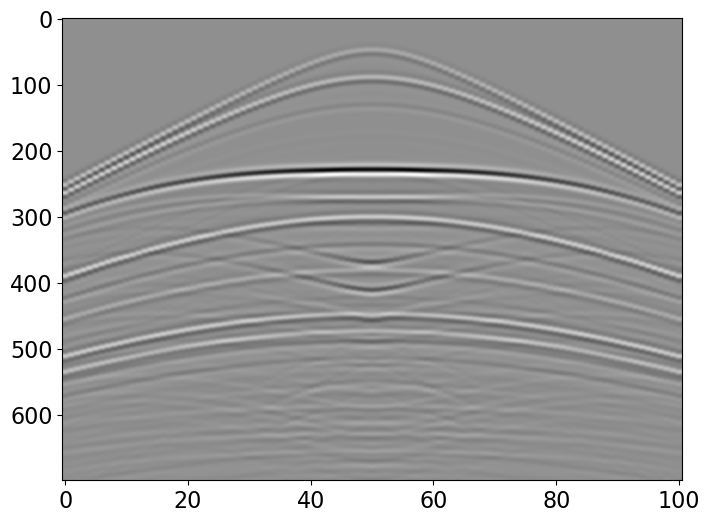

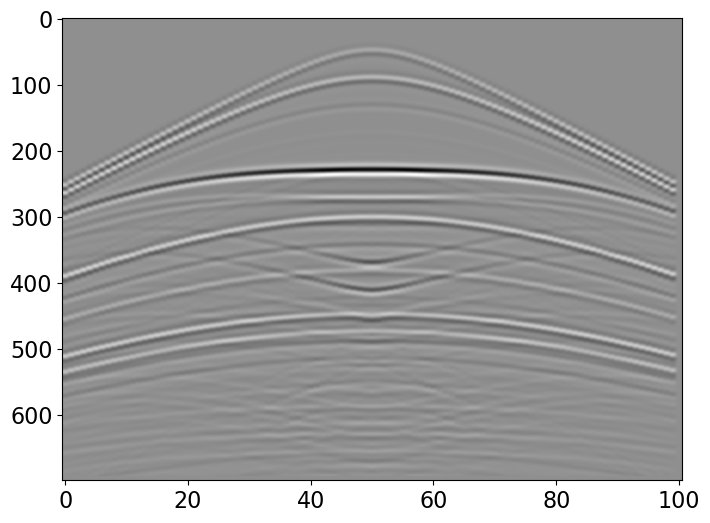

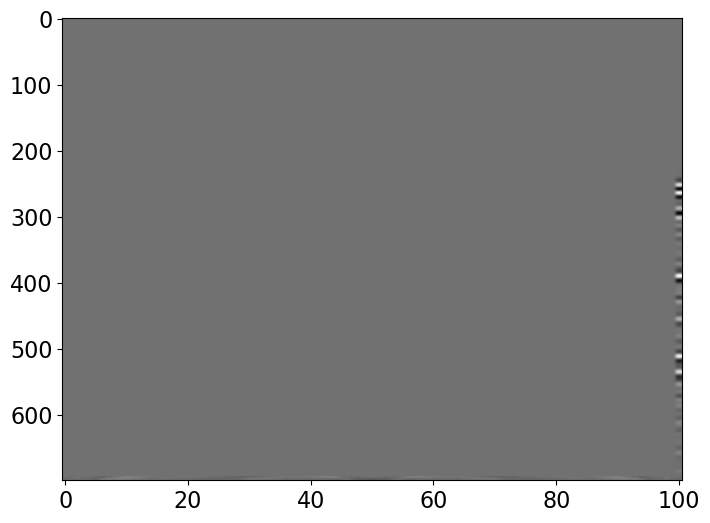

In [4]:
plt.figure()
plt.imshow(x.T, cmap='gray')
plt.axis('tight')

plt.figure()
plt.imshow(np.real(Sop * p).reshape(par['nx'], par['nt']).T, cmap='gray')
plt.axis('tight');

plt.figure()
plt.imshow(x.T - np.real(Sop * p).reshape(par['nx'], par['nt']).T, cmap='gray')
plt.axis('tight');

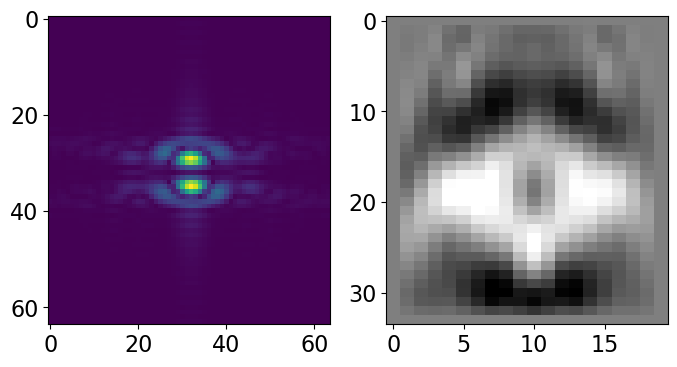

In [5]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch = 4*23 + 18

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(p[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * p[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

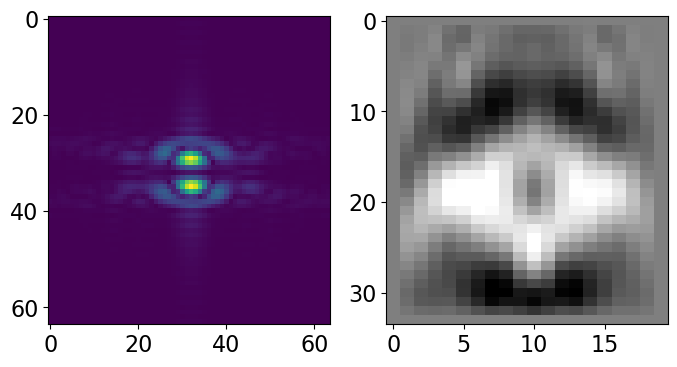

In [6]:
preshape = p.reshape(Sop.dims)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(preshape[4, 18].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * preshape[4, 18].ravel()).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

In [7]:
def callback(x, xhistory, Pop, xshape, xtrue=None, xerror=None):
    x = np.real(Pop * x).reshape(xshape).T
    xhistory.append(x)
    if xtrue is not None:
        xerror.append(np.linalg.norm(x-xtrue))

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 42700 rows and 847872 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 100
alpha = 2.500000e-01	thresh = 6.250000e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    7.075e-01   8.452e-01   2.400e-01
     2   -0.00e+00+0.00e+00j    5.331e-01   7.715e-01   1.865e-01
     3   -0.00e+00+0.00e+00j    3.901e-01   7.232e-01   1.878e-01
     4   -0.00e+00+0.00e+00j    2.864e-01   6.985e-01   1.736e-01
     5   -0.00e+00+0.00e+00j    2.173e-01   6.888e-01   1.519e-01
     6   -0.00e+00+0.00e+00j    1.737e-01   6.849e-01   1.295e-01
     7   -0.00e+00+0.00e+00j    1.468e-01   6.809e-01   1.111e-01
     8   -0.00e+00+0.00e+00j    1.303e-01   6.746e-01   9.818e-02
     9   -0.00e+00+0.00e+00j    1.202e-01   6.662e-01   8.966e-02
    10   -0.0

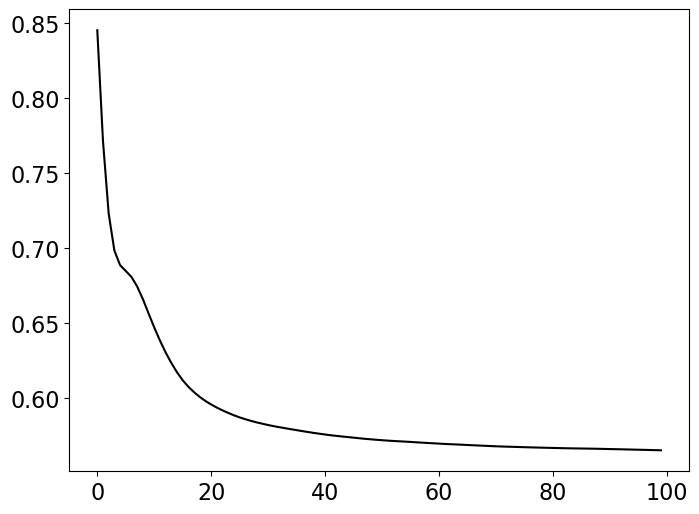

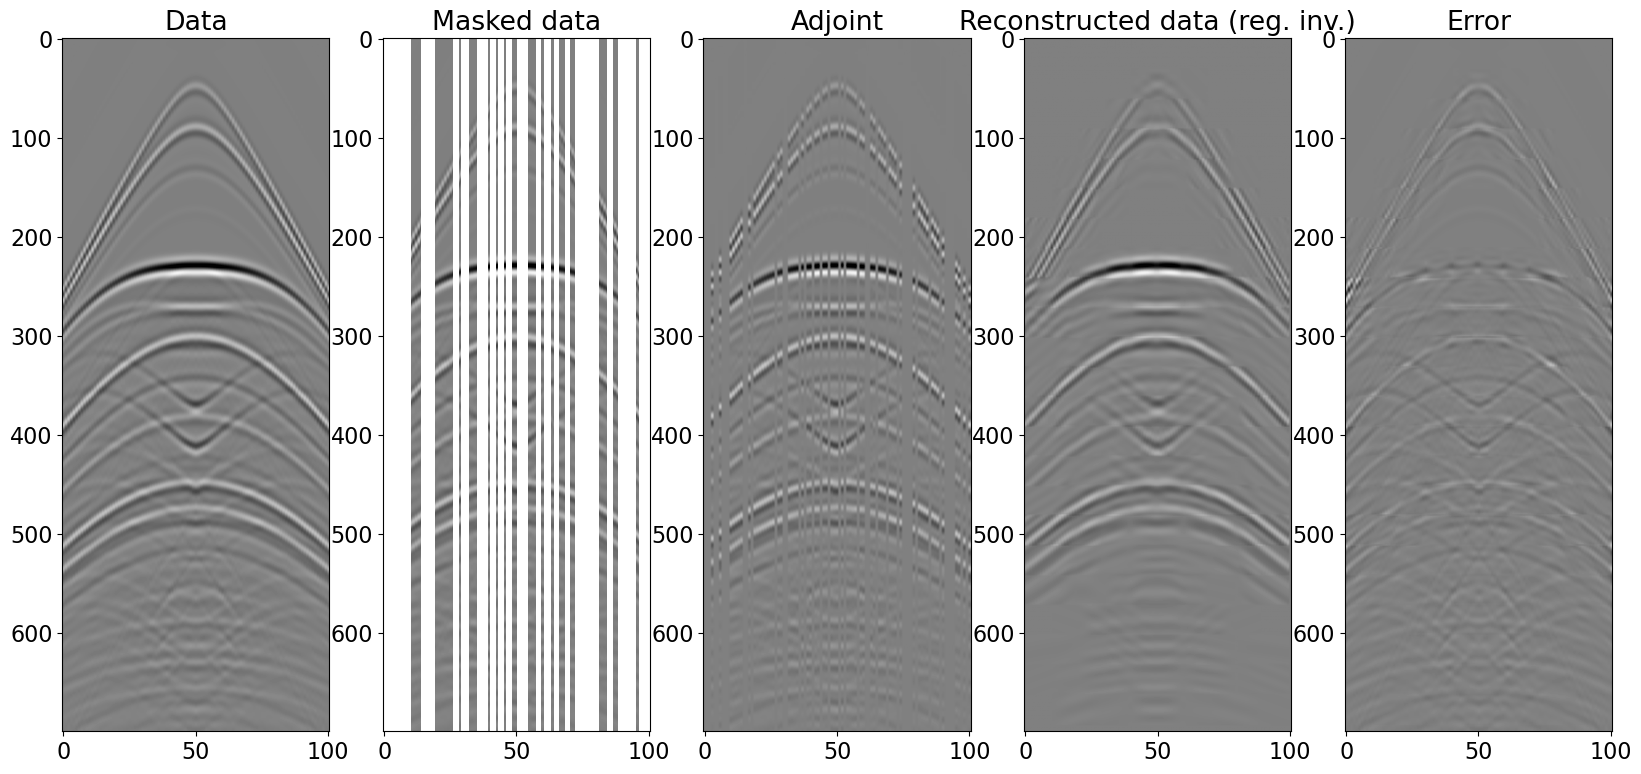

In [ ]:
# Synthesis problem with fixed thresholding
Op = Rop * Sop

niters = 100
xhist = []
xerror = []
prec, _, cost = fista(Op, y.ravel(), niter=niters, eps=5e-3, alpha=2.5e-1, #eigsiter=10, eigstol=1e-1, 
                      tol=1e-10, show=True, 
                      callback=lambda xinv: callback(xinv, xhist, Sop, (par['nx'], par['nt']), x.T, xerror))
xrec = np.real(Sop * prec)
xrec = xrec.reshape(par['nx'], par['nt'])
print('MSE', np.linalg.norm(x.T-xrec.T))

plt.figure()
plt.plot(cost, 'k')

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

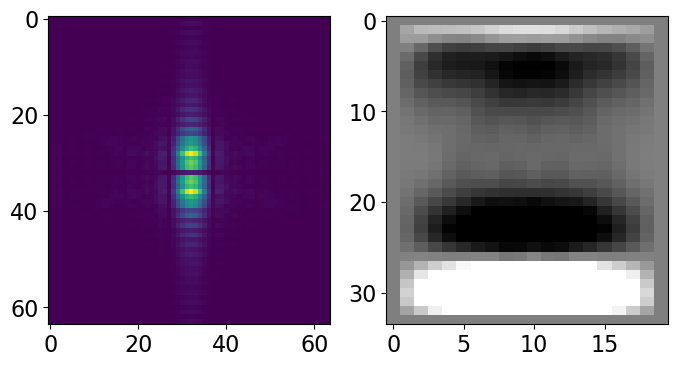

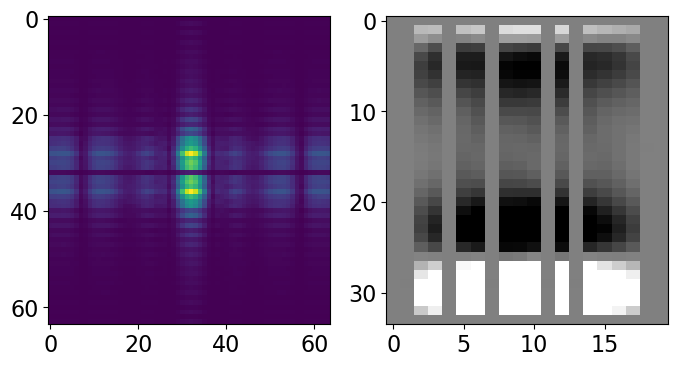

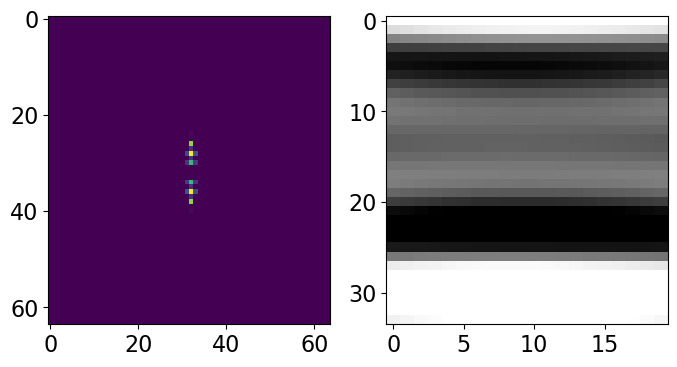

In [9]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch = 4*23 + 8

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(p[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * p[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(prec[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * prec[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

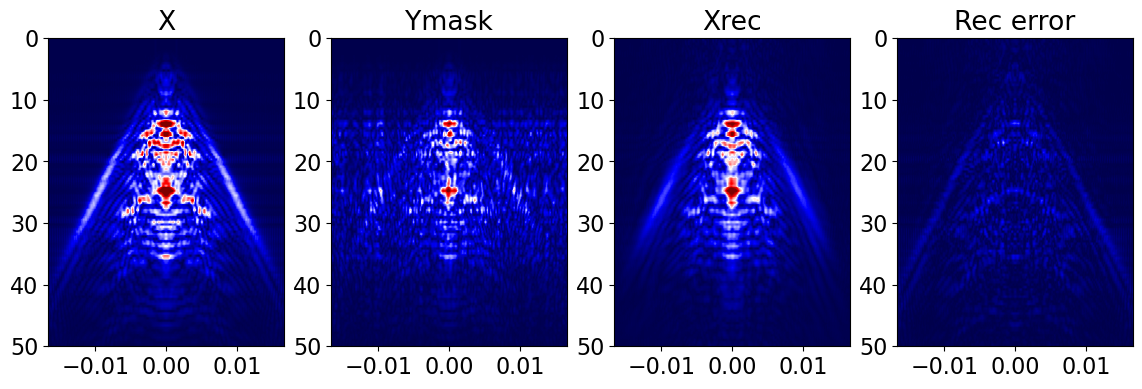

In [10]:
X = (FFTop * x.ravel()).reshape(nfft, nfft)
Y = (FFTop * ymask.ravel()).reshape(nfft, nfft)
Xrec = (FFTop * xrec.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[0].set_title('X')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[1].set_title('Ymask')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);
axs[2].imshow(np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[2].set_title('Xrec')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[3].imshow(np.abs(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T -
              np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T), cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[3].set_title('Rec error')
axs[3].axis('tight')
axs[3].set_ylim(50, 0);

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 42700 rows and 847872 cols
eps = 5.000000e-03	tol = 1.000000e-10	niter = 100
alpha = 2.500000e-01	thresh = 6.250000e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    7.075e-01   8.452e-01   2.400e-01
     2   -0.00e+00+0.00e+00j    5.292e-01   7.724e-01   1.893e-01
     3   -0.00e+00+0.00e+00j    3.805e-01   7.274e-01   1.928e-01
     4   -0.00e+00+0.00e+00j    2.711e-01   7.092e-01   1.800e-01
     5   -0.00e+00+0.00e+00j    1.972e-01   7.085e-01   1.584e-01
     6   -0.00e+00+0.00e+00j    1.499e-01   7.151e-01   1.349e-01
     7   -0.00e+00+0.00e+00j    1.202e-01   7.219e-01   1.141e-01
     8   -0.00e+00+0.00e+00j    1.014e-01   7.253e-01   9.839e-02
     9   -0.00e+00+0.00e+00j    8.912e-02   7.250e-01   8.764e-02
    10   -0.0

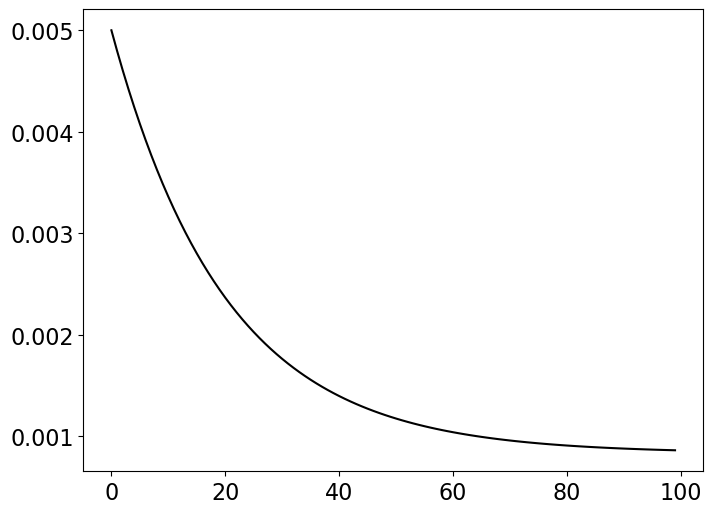

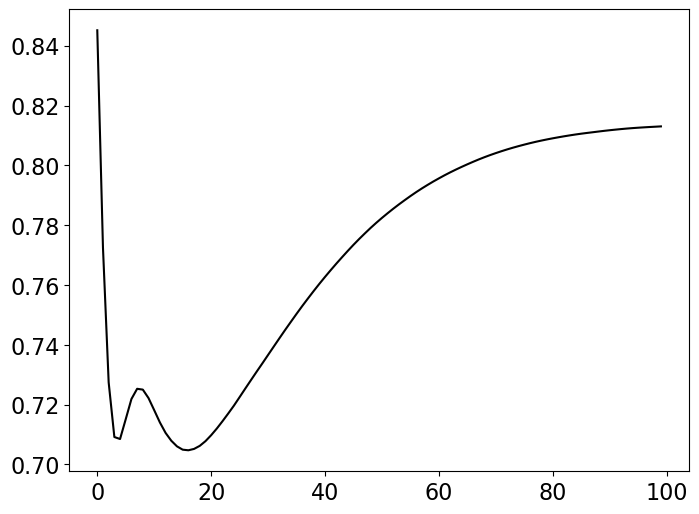

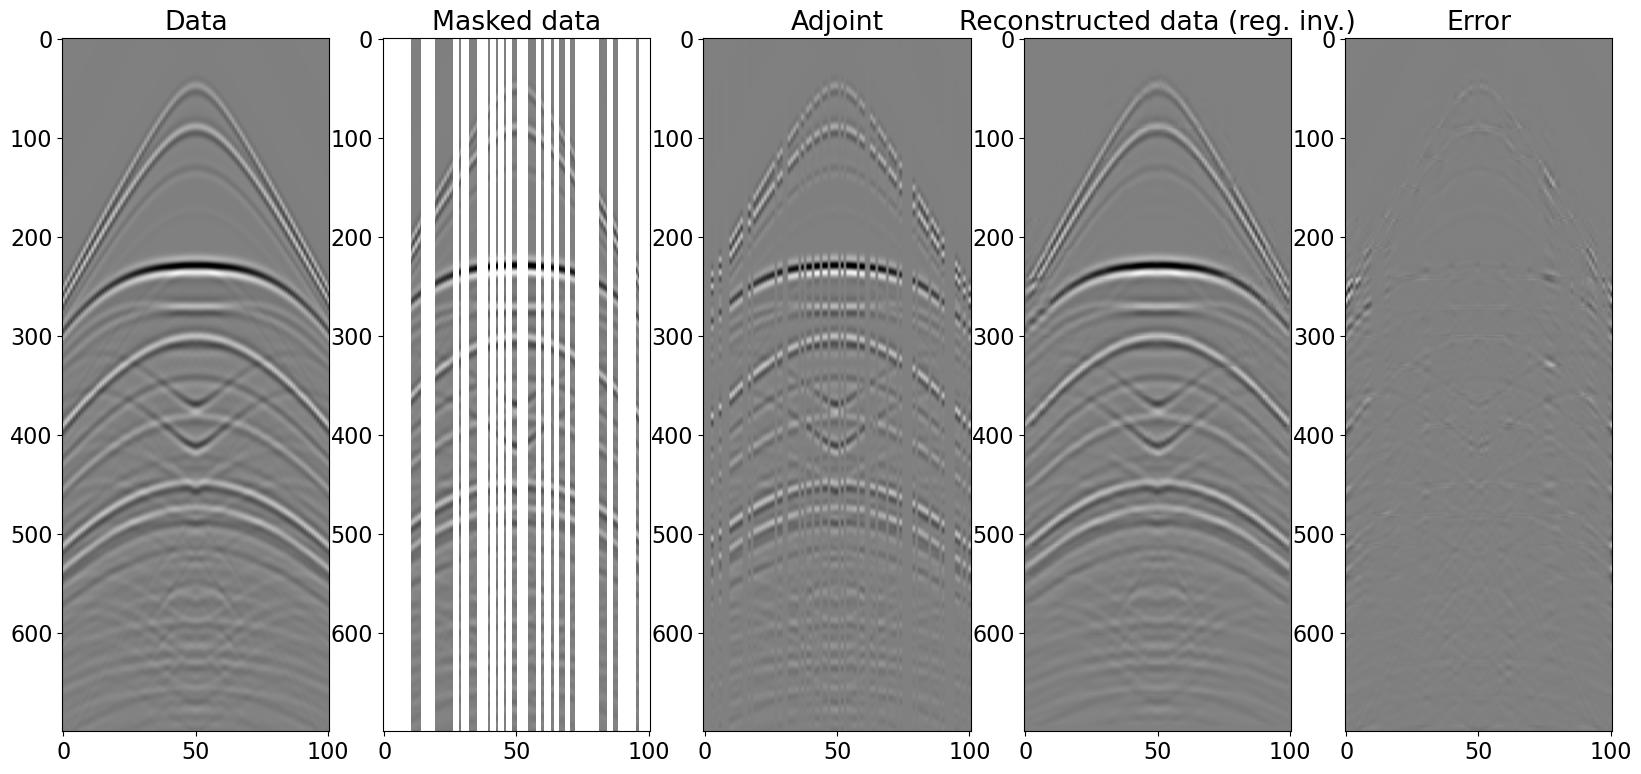

In [11]:
# Synthesis problem with thresholding decay
eps = 5e-3
niter = 100
decay = (np.exp(-0.05*np.arange(niter)) + 0.2) / 1.2
plt.figure()
plt.plot(eps*decay, 'k')

xhist = []
xerror = []
prec, _, cost = fista(Op, y.ravel(), niter=niter, eps=eps, alpha=2.5e-1, #eigsiter=10, eigstol=1e-1, 
                      decay=decay, tol=1e-10, show=True,
                      callback=lambda xinv: callback(xinv, xhist, Sop, (par['nx'], par['nt']), x.T, xerror))


xrec = np.real(Sop * prec)
xrec = xrec.reshape(par['nx'], par['nt'])
print('MSE', np.linalg.norm(x.T-xrec.T))

plt.figure()
plt.plot(cost, 'k')

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

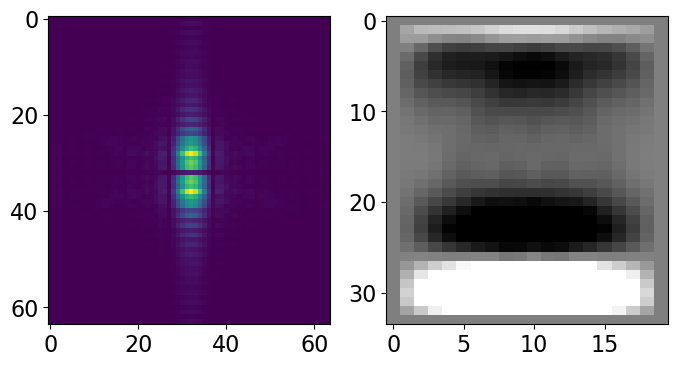

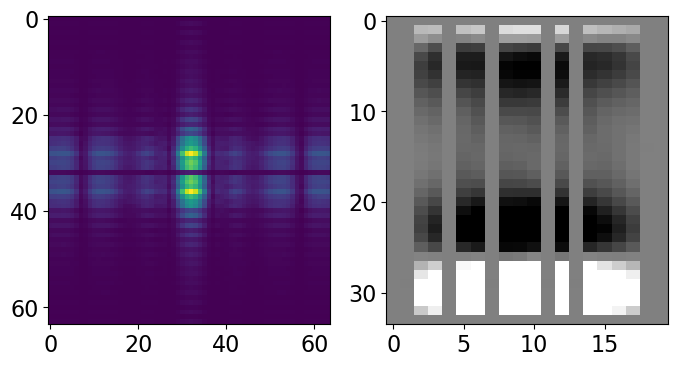

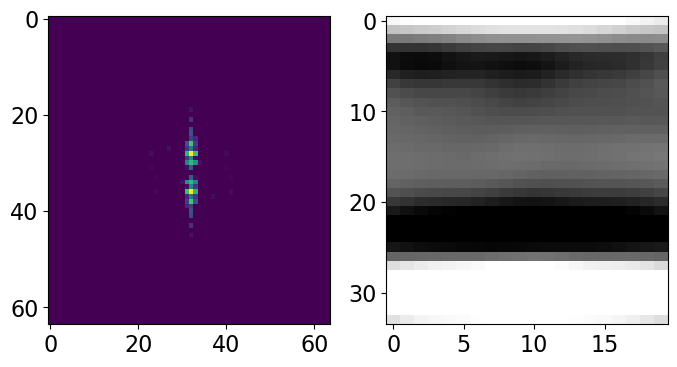

In [12]:
patches_inend = np.arange(0, nwins[0]*nwins[1]*nop[0]*nop[1], nop[0]*nop[1])
patches_inend = np.append(patches_inend, nwins[0]*nwins[1]*nop[0]*nop[1])

ipatch = 4*23 + 8

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(p[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * p[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * pmask[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.fft.fftshift(np.abs(prec[patches_inend[ipatch]:patches_inend[ipatch+1]].reshape(nop).T)))
axs[0].axis('tight')
axs[1].imshow(np.real((Fop.H * prec[patches_inend[ipatch]:patches_inend[ipatch+1]].T).reshape(nwin).T), cmap='gray',
           vmin=-0.005, vmax=0.005)
axs[1].axis('tight');

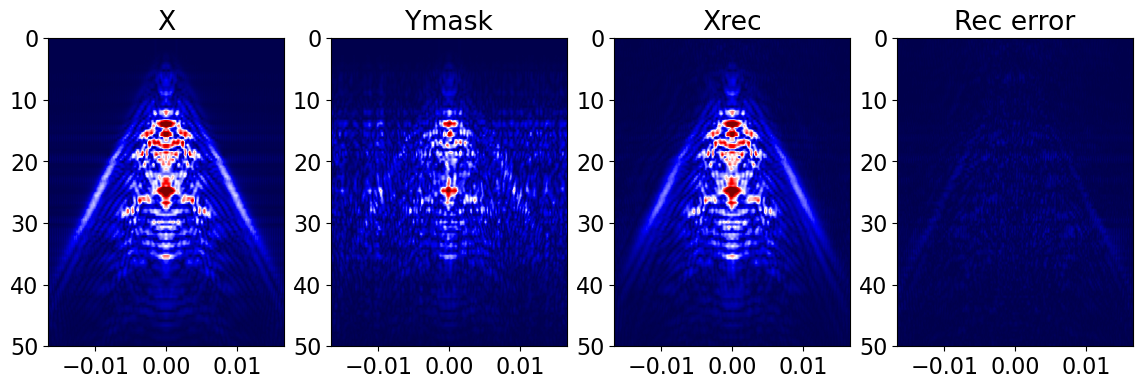

In [13]:
X = (FFTop* x.ravel()).reshape(nfft, nfft)
Y = (FFTop* ymask.ravel()).reshape(nfft, nfft)
Xrec = (FFTop * xrec.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[0].set_title('X')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[1].set_title('Ymask')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);
axs[2].imshow(np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[2].set_title('Xrec')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[3].imshow(np.abs(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T -
              np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T), cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[3].set_title('Rec error')
axs[3].axis('tight')
axs[3].set_ylim(50, 0);

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 42700 rows and 70700 cols
eps = 1.000000e-02	tol = 1.000000e-10	niter = 100
alpha = 1.000000e+00	thresh = 5.000000e-03
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    4.012e-01   1.058e+00   7.043e-01
     2   0.00e+00+0.00e+00j    3.482e-01   1.165e+00   1.588e-01
     3   0.00e+00+0.00e+00j    3.118e-01   1.245e+00   1.303e-01
     4   0.00e+00+0.00e+00j    2.886e-01   1.299e+00   1.010e-01
     5   0.00e+00+0.00e+00j    2.719e-01   1.335e+00   6.462e-02
     6   0.00e+00+0.00e+00j    2.597e-01   1.359e+00   3.175e-02
     7   0.00e+00+0.00e+00j    2.495e-01   1.378e+00   2.224e-02
     8   0.00e+00+0.00e+00j    2.396e-01   1.396e+00   2.133e-02
     9   0.00e+00+0.00e+00j    2.299e-01   1.414e+00   2.066e-02
    10   0.00e+00+0.00e

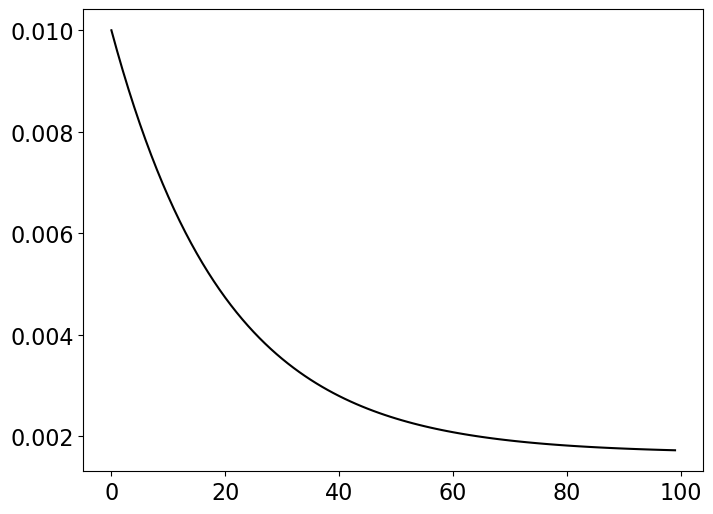

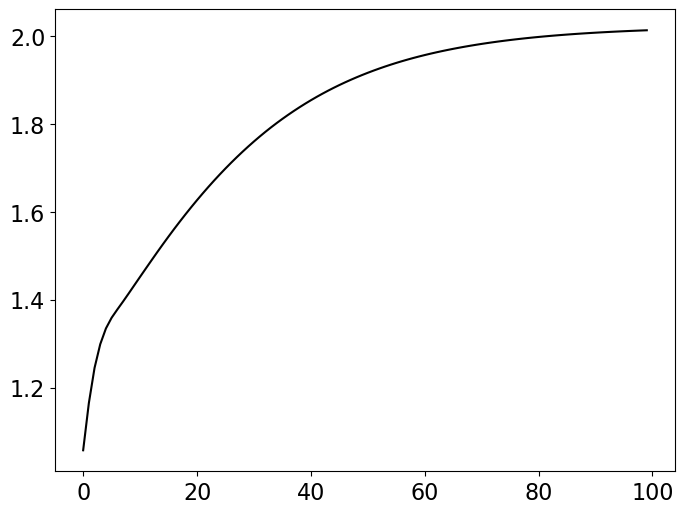

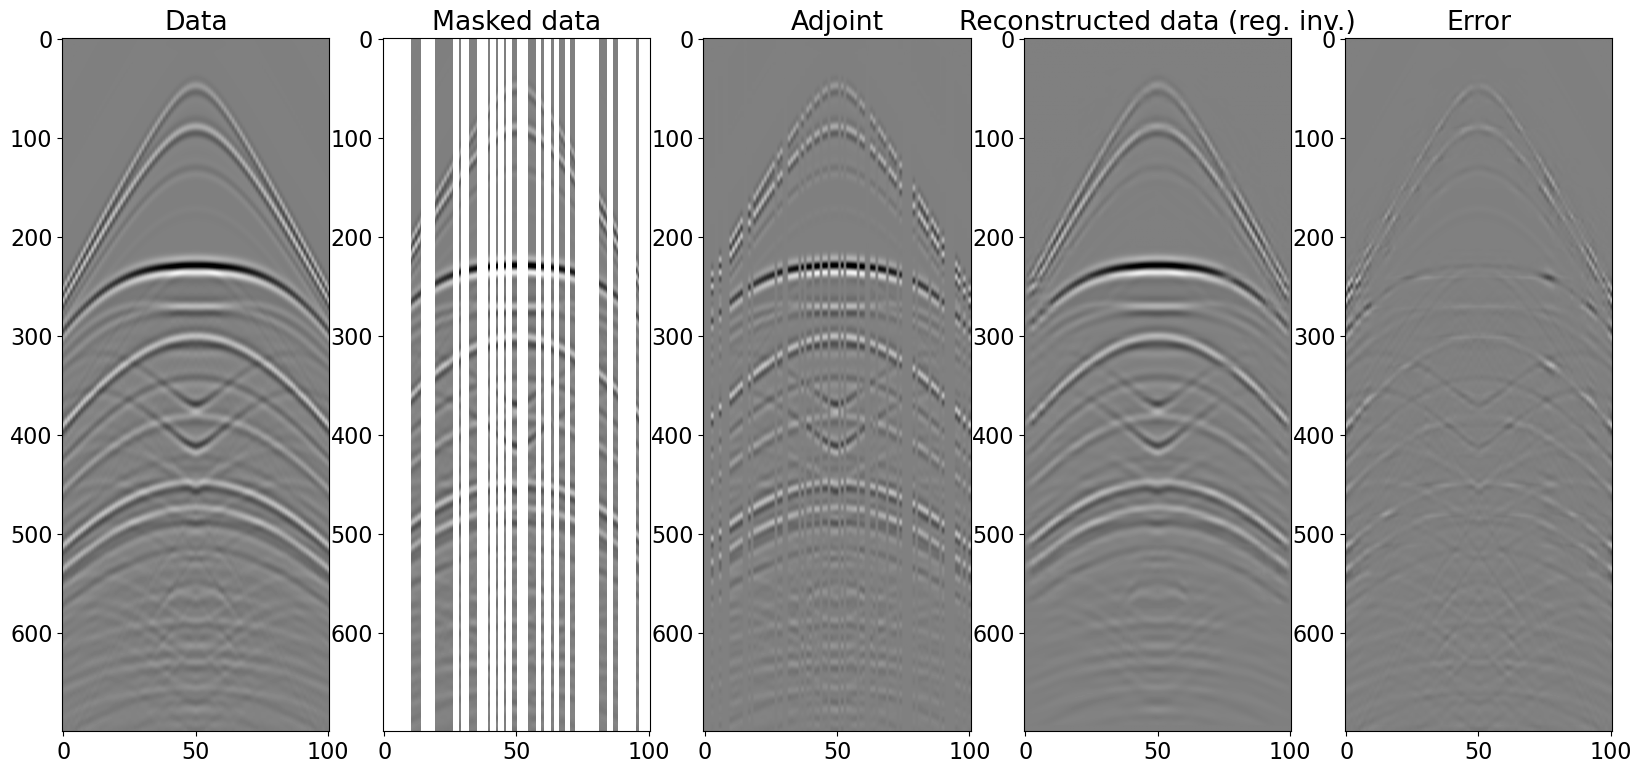

In [14]:
# Analysis problem with thresholding decay
eps = 1e-2
niter = 100
decay = (np.exp(-0.05*np.arange(niter)) + 0.2) / 1.2
plt.figure()
plt.plot(eps*decay, 'k')

Rop.dtype = np.complex128
xrec, _, cost = fista(Rop, y.ravel(), niter=niter, eps=eps, alpha=1., #eigsiter=10, eigstol=1e-1, 
                      SOp=Sop, decay=decay, tol=1e-10, show=True)
xrec = np.real(xrec.reshape(par['nx'], par['nt']))
print('MSE', np.linalg.norm(x.T-xrec.T))

plt.figure()
plt.plot(cost, 'k')

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xrec.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

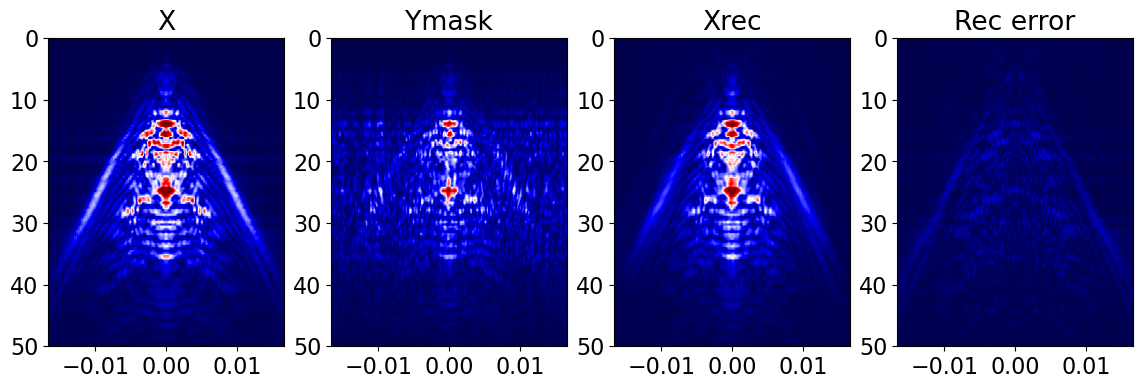

In [15]:
X = (FFTop* x.ravel()).reshape(nfft, nfft)
Y = (FFTop* ymask.ravel()).reshape(nfft, nfft)
Xrec = (FFTop * xrec.ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[0].set_title('X')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[1].imshow(np.fft.fftshift(np.abs(Y[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[1].set_title('Ymask')
axs[1].axis('tight')
axs[1].set_ylim(50, 0);
axs[2].imshow(np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T, cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[2].set_title('Xrec')
axs[2].axis('tight')
axs[2].set_ylim(50, 0)
axs[3].imshow(np.abs(np.fft.fftshift(np.abs(X[:, :nfft//2-1]),axes=0).T -
              np.fft.fftshift(np.abs(Xrec[:, :nfft//2-1]),axes=0).T), cmap='seismic',
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]), vmin=0, vmax=0.02)
axs[3].set_title('Rec error')
axs[3].axis('tight')
axs[3].set_ylim(50, 0);